# Simple implementation of the algorithm presented in the MCNLM paper

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

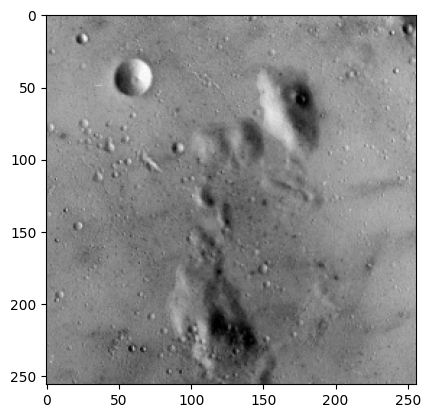

In [29]:
img = cv2.imread('../imgs/moon.tiff', 0)

# we need to normalize
img = img.astype(np.float64) / 255.0
plt.imshow(img, cmap='gray')
plt.show()

Add gaussian noise

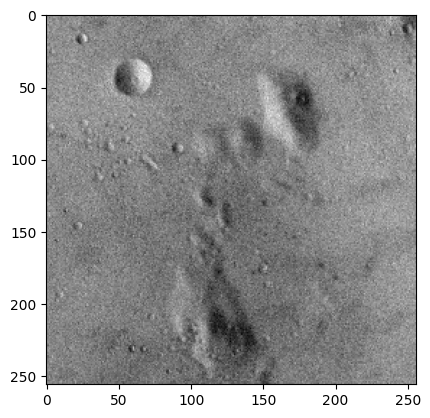

In [31]:
sd = 17.0 / 255.0
noisy_img = img + np.random.normal(0, sd, size=img.shape)

plt.imshow(noisy_img, cmap='gray')
plt.show()

Implement the algorithm like in the paper, profiting from `np` vectorisation.

In [32]:
def mcnlm(noisy_patch: np.ndarray, ref_patches: np.ndarray, probs: np.ndarray, h: float) -> float:
    """
    noisy_patch: what we denoise (yi)
    ref_patches: the X databse
    probs: the probability vector
    h: the scalar that helps us filter how similar two patches need to be
        - large h, accepts patches that are different
        - smaller h, forces the patches to be more similar
    """
    n = len(ref_patches)
    i_vect = np.random.random(n) < probs # n Bernoulli vars
    selected_indices = np.where(i_vect)[0]
    if len(selected_indices) == 0:
        return noisy_patch[len(noisy_patch) // 2]

    selected_patches = ref_patches[selected_indices]
    selected_probs = probs[selected_indices]

    # compute weight
    diffs = selected_patches - noisy_patch
    dists_sq = np.sum(diffs**2, axis=1) # this is simple, in the paper they use a lambda matrix, we need to look into it
    weights = np.exp(-dists_sq / (h**2))
    weights /= selected_probs

    # patch is square, same size
    center_idx = len(noisy_patch) // 2
    center_pixels = selected_patches[:, center_idx]

    sum_A = np.sum(weights * center_pixels)
    sum_B = np.sum(weights)

    if sum_B == 0:
        return noisy_patch[center_idx]

    return sum_A / sum_B


Our `ref_patches`, which is the $\mathcal{X}$ data base in the paper, will consist of all possbile patches


In [33]:
def get_all_patches(image: np.ndarray, patch_size: int) -> np.ndarray:
    h, w = image.shape
    pad = patch_size // 2

    patches = []

    for r in range(pad, h - pad):
        for c in range(pad, w - pad):
            p = image[r-pad : r+pad+1, c-pad : c+pad+1]
            patches.append(p.flatten())

    return np.array(patches)

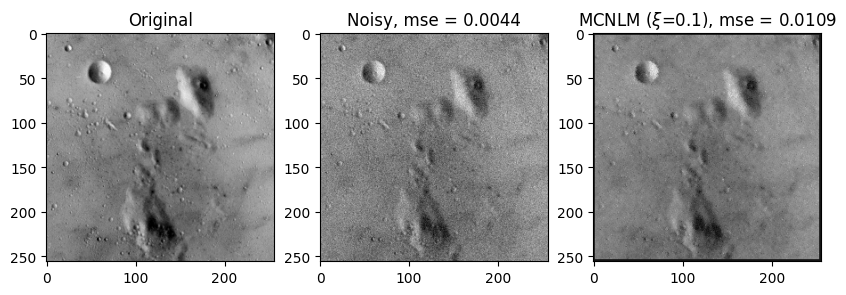

In [44]:
def get_mse(img1, img2):
    return np.mean((img1 - img2)**2)

patches_db = get_all_patches(noisy_img, 5)

# parameters
h = 0.4 * 5 * sd
xi = 0.1 # we want owe EV for the sum of the variables to be n * xi, most simply is to choose the prob for each variable to be xi
probs = np.full(len(patches_db), xi)
patch_size = 5
pad = patch_size // 2

height, width = noisy_img.shape
denoised_img = np.zeros_like(noisy_img)

for i in range(pad, height - pad):
    for j in range(pad, width - pad):
        y_patch = noisy_img[i-pad : i+pad+1, j-pad : j+pad+1].flatten()
        pixel_val = mcnlm(y_patch, patches_db, probs, h)
        denoised_img[i, j] = pixel_val

valid = (slice(pad, -pad), slice(pad, -pad))
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(noisy_img, cmap='gray')
plt.title(f"Noisy, mse = {get_mse(img[valid], noisy_img[valid]):.4f}")
plt.subplot(1, 3, 3)
plt.imshow(denoised_img, cmap='gray')
plt.title(rf"MCNLM ($\xi$={xi}), mse = {get_mse(img, denoised_img):.4f}")
plt.show()